In [1]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt
import json
import pandas as pd
from datetime import datetime
from copy import deepcopy
import dill
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F
from torchvision import transforms
import lovely_tensors as lt
from nnfabrik.builder import get_data
from focal_frequency_loss import FocalFrequencyLoss as FFL

import csng
from csng.InvertedEncoder import InvertedEncoder
from csng.CNN_Decoder import CNN_Decoder
from csng.utils import crop, plot_comparison, standardize, normalize, get_mean_and_std, count_parameters, plot_losses
from csng.losses import (
    MultiSSIMLoss,
    SSIMLoss,
    CroppedLoss,
    Loss,
    MS_SSIMLoss,
    PerceptualLoss,
    EncoderPerceptualLoss,
    VGGPerceptualLoss,
)
from csng.data import MixedBatchLoader
from csng.readins import (
    MultiReadIn,
    HypernetReadIn,
    ConvReadIn,
    AttentionReadIn,
    FCReadIn,
    AutoEncoderReadIn,
    Conv1dReadIn,
)

from BoostedInvertedEncoder import BoostedInvertedEncoder
from encoder import get_encoder
from data_utils import get_mouse_v1_data, PerSampleStoredDataset, append_syn_dataloaders, append_data_aug_dataloaders
from comparison_utils import (
    eval_decoder,
    get_all_data,
    plot_reconstructions,
    plot_metrics,
    plot_over_training,
    plot_reconstructions_publication,
    plot_metrics_publication,
)

lt.monkey_patch()

DATA_PATH = os.path.join(os.environ["DATA_PATH"], "mouse_v1_sensorium22")
print(f"{DATA_PATH=}")

/home/jsobotka/.local/lib/python3.10/site-packages/scipy/__init__.py:155: UserWarning: A NumPy version >=1.18.5 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'
DATA_PATH='/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22'


In [2]:
config = {
    "data": {
        "mixing_strategy": "sequential", # needed only with multiple base dataloaders
    },
    "device": "cuda" if torch.cuda.is_available() else "cpu",
    "seed": 0,
    "crop_win": (22, 36),
}
print(f"... Running on {config['device']} ...")

... Running on cuda ...


In [3]:
np.random.seed(config["seed"])
torch.manual_seed(config["seed"])
random.seed(config["seed"])

## Data

In [4]:
dataloaders = dict()
config["data"]["mouse_v1"] = None
config["data"]["syn_dataset_config"] = None
config["data"]["data_augmentation"] = None

### Mouse V1 dataset (Sensorium 2022)

In [36]:
### prep data config
config["data"]["mouse_v1"] = {
    "dataset_fn": "sensorium.datasets.static_loaders",
    "dataset_config": {
        "paths": [ # from https://gin.g-node.org/cajal/Sensorium2022/src/master
            # os.path.join(DATA_PATH, "static26872-17-20-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # mouse 1
            # os.path.join(DATA_PATH, "static27204-5-13-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # sensorium+ (mouse 2)
            os.path.join(DATA_PATH, "static21067-10-18-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 3)
            os.path.join(DATA_PATH, "static22846-10-16-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 4)
            os.path.join(DATA_PATH, "static23343-5-17-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 5)
            os.path.join(DATA_PATH, "static23656-14-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 6)
            os.path.join(DATA_PATH, "static23964-4-22-GrayImageNet-94c6ff995dac583098847cfecd43e7b6.zip"), # pretraining (mouse 7)
        ],
        "normalize": True,
        "scale": 0.25, # 256x144 -> 64x36
        "include_behavior": False,
        "add_behavior_as_channels": False,
        "include_eye_position": True,
        "exclude": None,
        "file_tree": True,
        "cuda": "cuda" in config["device"],
        "batch_size": 7,
        "seed": config["seed"],
        "use_cache": False,
    },
    "skip_train": False,
    "skip_val": False,
    "skip_test": False,
    "normalize_neuron_coords": True,
    "average_test_multitrial": True,
    "save_test_multitrial": True,
    "test_batch_size": 7,
    "device": config["device"],
}

In [37]:
### get dataloaders and cell coordinates
dataloaders, neuron_coords = get_mouse_v1_data(config["data"])

Training dataset:	 22414 samples
Validation dataset:	 2527 samples
Test dataset:		 525 samples
Test (no resp) dataset:	 0 samples

stimuli:
  torch.Size([7, 1, 36, 64])
  min=-1.750  max=2.225
  mean=0.093  std=0.944
responses:
  torch.Size([7, 8372])
  min=0.000  max=12.693
  mean=0.290  std=0.544
neuronal coordinates:
  torch.Size([8372, 3])
  min=-1.000  max=1.000
  mean=0.002  std=0.593


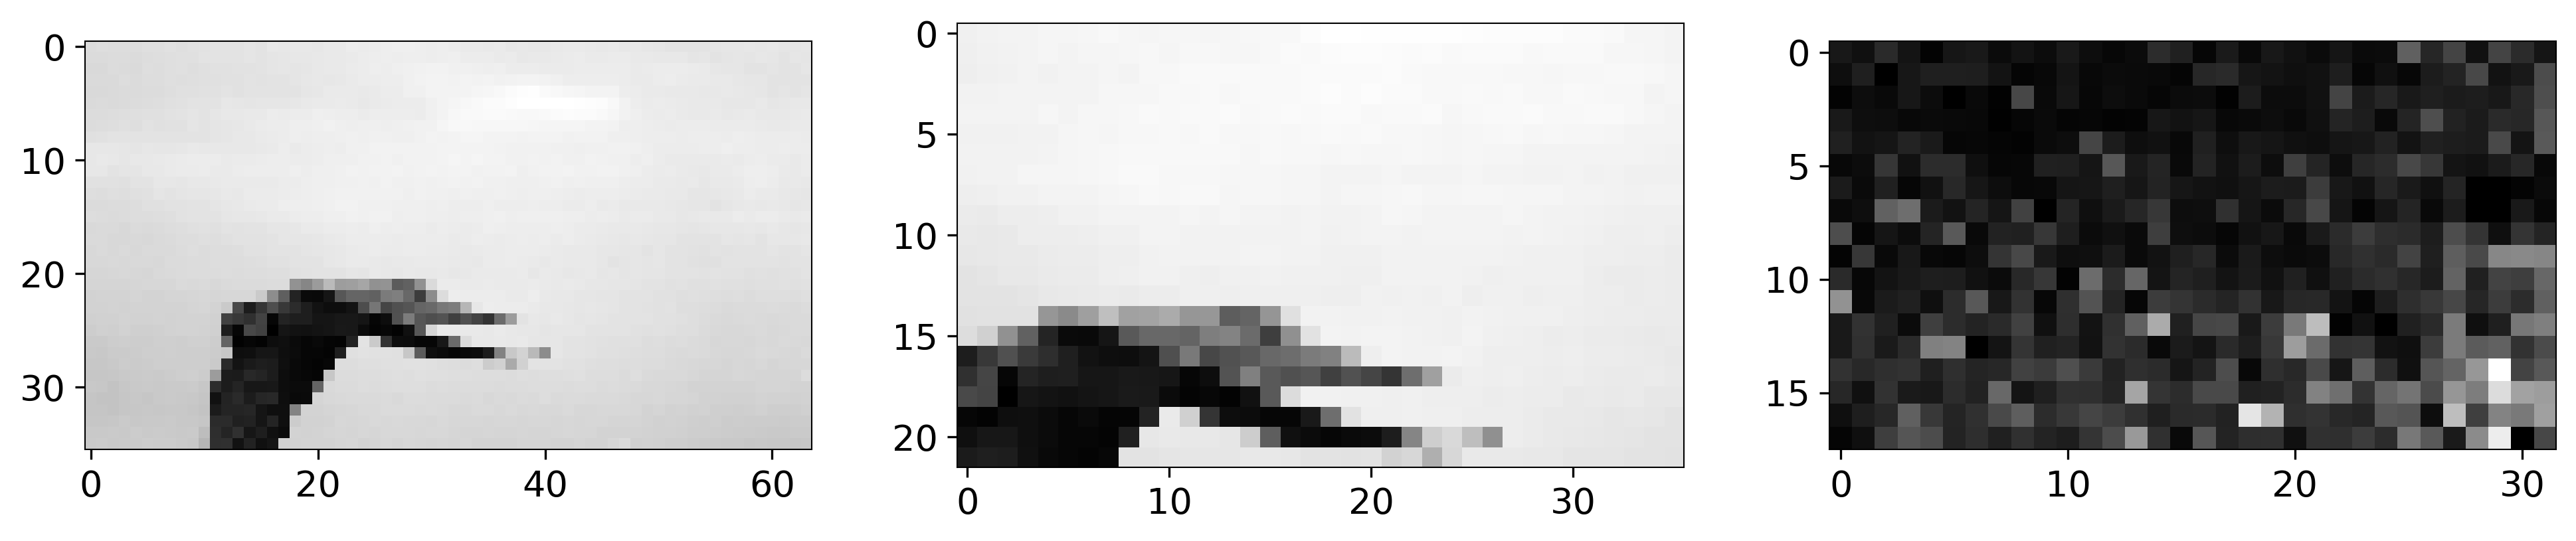

In [38]:
### show data
sample_data_key = dataloaders["mouse_v1"]["test"].data_keys[0]
datapoint = next(iter(dataloaders["mouse_v1"]["test"].dataloaders[0]))
stim, resp = datapoint.images, datapoint.responses
pupil_center = datapoint.pupil_center
print(
    f"Training dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['train'].dataloaders)} samples"
    f"\nValidation dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['val'].dataloaders)} samples"
    f"\nTest dataset:\t\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test'].dataloaders)} samples"
    f"\nTest (no resp) dataset:\t {sum(len(dl) * config['data']['mouse_v1']['dataset_config']['batch_size'] for dl in dataloaders['mouse_v1']['test_no_resp'].dataloaders)} samples"

    "\n\nstimuli:"
    f"\n  {stim.shape}"
    f"\n  min={stim.min().item():.3f}  max={stim.max().item():.3f}"
    f"\n  mean={stim.mean().item():.3f}  std={stim.std().item():.3f}"
    "\nresponses:"
    f"\n  {resp.shape}"
    f"\n  min={resp.min().item():.3f}  max={resp.max().item():.3f}"
    f"\n  mean={resp.mean().item():.3f}  std={resp.std().item():.3f}"
    "\nneuronal coordinates:"
    f"\n  {neuron_coords[sample_data_key].shape}"
    f"\n  min={neuron_coords[sample_data_key].min():.3f}  max={neuron_coords[sample_data_key].max():.3f}"
    f"\n  mean={neuron_coords[sample_data_key].mean():.3f}  std={neuron_coords[sample_data_key].std():.3f}"
)

### plot sample data
sample_idx = 0

fig = plt.figure(figsize=(16, 6))
ax = fig.add_subplot(131)
ax.imshow(stim[sample_idx].squeeze().unsqueeze(-1).cpu(), cmap="gray")

ax = fig.add_subplot(132)
ax.imshow(crop(stim[sample_idx].cpu(), config["crop_win"]).squeeze().unsqueeze(-1), cmap="gray")

### bin the neuronal responses based on their neuron coordinates and sum within each bin -> 2D grid of vals
coords = neuron_coords[sample_data_key]
H, W = stim.shape[-2:] # the size of the grid
n_x_bins, n_y_bins = 32, 18 # number of bins in each dimension
min_x, max_x, min_y, max_y = coords[:,0].min().item(), coords[:,0].max().item(), coords[:,1].min().item(), coords[:,1].max().item()
x_bins = torch.linspace(min_x, max_x, n_x_bins + 1)
y_bins = torch.linspace(min_y, max_y, n_y_bins + 1)
binned_resp = torch.zeros(n_y_bins, n_x_bins)
for i in range(n_y_bins):
    for j in range(n_x_bins):
        ### mask of the neurons in the bin
        mask = (x_bins[j] <= coords[:,0]) &\
               (coords[:,0] < x_bins[j + 1]) &\
               (y_bins[i] <= coords[:,1]) &\
               (coords[:,1] < y_bins[i + 1])
        binned_resp[i,j] = resp[sample_idx, mask.cpu()].sum(0)
ax = fig.add_subplot(133)
ax.imshow(binned_resp.squeeze().cpu(), cmap="gray")

plt.show()

## Encoder

In [ ]:
encoder = get_encoder(device=config["device"], eval_mode=True)

## Compare decoders

In [39]:
config["comparison"] = {
    # "load_best": False,
    "load_best": True,
    # "eval_all_ckpts": True,
    "eval_all_ckpts": False,
    "find_best_ckpt_according_to": None,
    # "find_best_ckpt_according_to": "Perceptual Loss (VGG16)",
    "save_dir": None,
    "save_dir": os.path.join(
        "results",
        "fig1",
    ),
    "load_ckpt": None,
    # "load_ckpt": {
    #     "path": os.path.join(
    #         "results",
    #         "fig1",
    #         "2024-04-08_15-23-37.pt",
    #     ),
    # },
}

In [40]:
runs_to_compare = {}

In [42]:
if config["comparison"]["load_ckpt"] is not None:
    print(f"Loading checkpoint from {config['comparison']['load_ckpt']['path']}...")
    runs_to_compare.update(
        torch.load(config["comparison"]["load_ckpt"]["path"], map_location=config["device"])
    )

In [ ]:
### config for collecting results (1)
runs_to_compare = {}
runs_to_compare = torch.load(
    "encoder_inversion_eval_all_mice_26-03-24.pt", pickle_module=dill
)

In [ ]:
""" Encoder Inversion """
# runs_to_compare["Inverted Encoder"] = torch.load("encoder_inversion_eval_all_mice.pt", pickle_module=dill)["Inverted Encoder"]
runs_to_compare["Inverted Encoder"] = {
    "decoder": InvertedEncoder(
        encoder=encoder,
        img_dims=stim.shape[1:],
        stim_pred_init="zeros",
        opter_cls=torch.optim.SGD,
        opter_config={"lr": 1500, "momentum": 0},
        n_steps=400,
        resp_loss_fn=F.mse_loss,
        stim_loss_fn=SSIMLoss(
            window=config["crop_win"],
            log_loss=True,
            inp_normalized=True,
            inp_standardized=False,
        ),
        img_gauss_blur_config=None,
        img_grad_gauss_blur_config={"kernel_size": 17, "sigma": 2},
        device=config["device"],
    ).to(config["device"]),
    "run_name": None
}

In [ ]:
### config for collecting results (2)
# ### FCReadIn
# "FCReadIn": {
#     "run_name": "2024-02-25_17-09-59",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-25_17-09-59", "decoder.pt"),
# },
# "FCReadIn - Autoencoding": {
#     "run_name": "2024-02-27_00-27-17",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-27_00-27-17", "decoder.pt"),
# },
# "FCReadIn - Contrastive reg.": {
#     "run_name": "2024-02-28_21-27-46",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_21-27-46", "decoder.pt"),
# },

# ### ConvReadIn
# "ConvReadIn": {
#     "run_name": "2024-02-25_21-16-59",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-25_21-16-59", "decoder.pt"),
# },
# # "ConvReadIn - no shift": {
# "ConvReadIn - no pupil center training": {
#     "run_name": "2024-03-06_12-46-53",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-06_12-46-53", "decoder.pt"),
# },
# "ConvReadIn - Autoencoding": {
#     "run_name": "2024-02-27_13-01-15",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-27_13-01-15", "decoder.pt"),
# },
# "ConvReadIn - Contrastive reg.": {
#     "run_name": "2024-02-27_00-04-30",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-27_00-04-30", "decoder.pt"),
# },
# "ConvReadIn - Fine-tuned": {
#     "run_name": "2024-02-28_00-55-12",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_00-55-12", "decoder.pt"),
# },
# "ConvReadIn - From scratch": { # comparison to the above
#     "run_name": "2024-02-28_00-59-51",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_00-59-51", "decoder.pt"),
# },
# runs_to_compare["ConvReadIn - Con. reg."] = {
#     "run_name": "2024-03-02_12-28-42",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-02_12-28-42", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn - Con. reg., no shifter"] = {
#     "run_name": "2024-03-18_01-12-49",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-18_01-12-49", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn - Con. reg. + Fine-tuned"] = {
#         "run_name": "2024-02-28_13-08-22",
#         "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_13-08-22", "decoder.pt"),
#     }
# runs_to_compare["ConvReadIn - Con. reg. (large) with neuron embeddings"] = {
#     "run_name": "2024-03-03_00-59-02",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-03_00-59-02", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn - Con. reg. + Data aug."] = {
#     "run_name": "2024-03-08_13-08-36",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-08_13-08-36", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn - Synth. data 43%"] = {
#     "run_name": "2024-03-11_01-05-34",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-11_01-05-34", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn - Synth. data 30% + Data aug."] = {
#     "run_name": "2024-03-11_20-03-03",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-11_20-03-03", "decoder.pt"),
# }
# runs_to_compare["Con. reg."] = {
#     "run_name": "2024-03-18_01-12-49",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-18_01-12-49", "decoder.pt"),
# }



### Single datasets
# runs_to_compare["ConvReadIn (mouse #1) - Fine-tuned"] = {
#     "run_name": "2024-02-28_13-09-19",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_13-09-19", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn (mouse #1) - From scratch"] = {
#     "run_name": "2024-02-28_15-10-47",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-02-28_15-10-47", "decoder.pt"),
# }
# "ConvReadIn (mouse #1) - With neuron embeddings": {
#     "run_name": "2024-03-03_19-47-31",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-03_19-47-31", "decoder.pt"),
# },
# runs_to_compare["ConvReadIn (mouse #1) - From scratch + Synth. data 50%"] = {
#     "run_name": "2024-03-10_21-32-52",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-10_21-32-52", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn (mouse #1) - From scratch + Synth. data 40% + Data aug."] = {
#     "run_name": "2024-03-12_18-52-18",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-12_18-52-18", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn (mouse #1) - From scratch, SSIM"] = {
#     "run_name": "2024-03-16_17-13-54",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-16_17-13-54", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn (mouse #1) - From scratch, SSIM, no z-coord"] = {
#     "run_name": "2024-03-17_11-16-25",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-17_11-16-25", "decoder.pt"),
# }
# runs_to_compare["ConvReadIn (mouse #1) - From scratch, MultiSSIM"] = {
#     "run_name": "2024-03-16_21-01-52",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-16_21-01-52", "decoder.pt"),
# }
# "Boosted Inverted Encoder (mouse #1)": {
#     "run_name": "2024-03-06_01-15-13",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "boosted_inverted_encoder", "2024-03-06_01-15-13", "decoder.pt"),
# },
# "Boosted Inverted Encoder (mouse #1)": {
#     "run_name": "2024-03-07_01-01-23",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "boosted_inverted_encoder", "2024-03-07_01-01-23", "decoder.pt"),
# },

In [ ]:
""" MEIReadIn """
# runs_to_compare["ConvReadIn (all datasets)"] = {
#     "run_name": "2024-03-26_10-36-00",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-26_10-36-00", "decoder.pt"),
# }
# runs_to_compare["MEIReadIn (all datasets)"] = {
#     "run_name": "2024-03-24_14-24-59",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_14-24-59", "decoder.pt"),
# }

# runs_to_compare["ConvReadIn (mouse #1)"] = {
#     "run_name": "2024-03-24_11-07-15",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_11-07-15", "decoder.pt"),
# }
# runs_to_compare["MEIReadIn (mouse #1)"] = {
#     "run_name": "2024-03-25_16-22-15",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-25_16-22-15", "decoder.pt"),
# }

In [ ]:
""" Training w/ different loss functions """
runs_to_compare["Log SSIM"] = {
    "run_name": "2024-03-16_17-13-54",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-16_17-13-54", "decoder.pt"),
}
runs_to_compare["Log MultiSSIM"] = {
    "run_name": "2024-03-16_21-01-52",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-16_21-01-52", "decoder.pt"),
}
runs_to_compare["MSE"] = {
    "run_name": "2024-03-13_16-43-29",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-13_16-43-29", "decoder.pt"),
}
runs_to_compare["0.5 * MSE + 0.5 * Log SSIM"] = {
    "run_name": "2024-03-14_00-46-57",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-14_00-46-57", "decoder.pt"),
}
runs_to_compare["0.9 * MSE + 0.1 * Log SSIM"] = {
    "run_name": "2024-03-14_13-23-58",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-14_13-23-58", "decoder.pt"),
}
runs_to_compare["0.1 * MSE + 0.9 * Log SSIM"] = {
    "run_name": "2024-03-14_19-40-02",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-14_19-40-02", "decoder.pt"),
}
runs_to_compare["MAE"] = {
    "run_name": "2024-03-16_13-40-03",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-16_13-40-03", "decoder.pt"),
}
runs_to_compare["FFL"] = {
    "run_name": "2024-03-17_00-36-23",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-17_00-36-23", "decoder.pt"),
}

In [ ]:
""" Synthetic data comparison (new stimuli) """
### all datasets
# runs_to_compare["Synth. data 0%"] = {
#     "run_name": "2024-03-26_10-36-00",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-26_10-36-00", "decoder.pt"),
# }
# runs_to_compare["Synth. data 25%"] = {
#     "run_name": "2024-03-24_11-43-39",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_11-43-39", "decoder.pt"),
# }
# runs_to_compare["Synth. data 50%"] = {
#     "run_name": "2024-03-24_00-22-38",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_00-22-38", "decoder.pt"),
# }
# runs_to_compare["Synth. data 75%"] = {
#     "run_name": "2024-03-24_20-58-11",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_20-58-11", "decoder.pt"),
# }
runs_to_compare["Synth. data 87.5%"] = {
    "run_name": "2024-04-01_11-16-55",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-04-01_11-16-55", "decoder.pt"),
}
# runs_to_compare["Synth. data 100%"] = {
#     "run_name": "2024-03-25_21-37-04",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-25_21-37-04", "decoder.pt"),
# }

### single datasets
# runs_to_compare["Synth. data 0% (all datasets)"] = {
#     "run_name": "2024-03-26_10-36-00",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-26_10-36-00", "decoder.pt"),
# }
# runs_to_compare["Synth. data 0%"] = {
#     "run_name": "2024-03-24_11-07-15",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_11-07-15", "decoder.pt"),
# }
# runs_to_compare["Synth. data 25%"] = {
#     "run_name": "2024-03-24_11-10-27",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_11-10-27", "decoder.pt"),
# }
# runs_to_compare["Synth. data 25%, noise"] = {
#     "run_name": "2024-03-26_14-06-06",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-26_14-06-06", "decoder.pt"),
# }
# runs_to_compare["Synth. data 50%"] = {
#     "run_name": "2024-03-24_11-00-40",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_11-00-40", "decoder.pt"),
# }
# runs_to_compare["Synth. data 50%, noise"] = {
#     "run_name": "2024-03-26_10-09-50",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-26_10-09-50", "decoder.pt"),
# }
# runs_to_compare["Synth. data 75%"] = {
#     "run_name": "2024-03-25_16-13-34",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-25_16-13-34", "decoder.pt"),
# }
# runs_to_compare["Synth. data 100%"] = {
#     "run_name": "2024-03-25_23-47-06",
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-25_23-47-06", "decoder.pt"),
# }

In [ ]:
""" Fine-tuning """
runs_to_compare["Fine-tuned (all datasets -> mouse #1 data)"] = {
    "run_name": "2024-04-02_10-45-50",
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-04-02_10-45-50", "decoder.pt"),
}

In [46]:
""" Figure 1 """
# runs_to_compare = torch.load( # Inverted Encoder
#     "encoder_inversion_eval_all_mice_26-03-24.pt", pickle_module=dill
# )
# runs_to_compare["CNN-FC (M-1)"] = {
#     # "run_name": "2024-03-23_12-05-01",
#     "run_name": "2024-04-08_00-43-03",
#     # "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-23_12-05-01", "decoder.pt"),
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-04-08_00-43-03", "decoder.pt"),
# }
# runs_to_compare["CNN-Conv (M-1)"] = {
#     # "run_name": "2024-03-24_11-07-15",
#     "run_name": "2024-03-27_11-35-11",
#     # "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_11-07-15", "decoder.pt"),
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-27_11-35-11", "decoder.pt"),
# }
# runs_to_compare["CNN-MEI (M-1)"] = {
#     "run_name": "2024-03-25_16-22-15", # TODO: train larger to match Conv and FC
#     "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-25_16-22-15", "decoder.pt"),
# }
runs_to_compare["CNN-FC (M-All)"] = {
    # "run_name": "2024-04-07_15-46-17",
    "run_name": "2024-04-08_00-39-27",
    # "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-04-07_15-46-17", "decoder.pt"),
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-04-08_00-39-27", "decoder.pt"),
}
runs_to_compare["CNN-Conv (M-All)"] = {
    # "run_name": "2024-03-26_10-36-00",
    "run_name": "2024-03-27_23-26-05",
    # "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-26_10-36-00", "decoder.pt"),
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-27_23-26-05", "decoder.pt"),
}
runs_to_compare["CNN-MEI (M-All)"] = {
    "run_name": "2024-03-24_14-24-59", # TODO: train larger to match Conv and FC
    "ckpt_path": os.path.join(DATA_PATH, "models", "cnn", "2024-03-24_14-24-59", "decoder.pt"),
}

In [44]:
""" Metrics """
loss_fns = {
    "Log SSIM Loss": SSIMLoss(
        window=config["crop_win"],
        log_loss=True,
        inp_normalized=True,
        inp_standardized=False,
        reduction="sum",
    ),
    "Log MultiSSIM Loss": MultiSSIMLoss(
        window=config["crop_win"],
        log_loss=True,
        inp_normalized=True,
        inp_standardized=False,
        reduction="sum",
    ),
    "SSIM Loss": SSIMLoss(
        window=config["crop_win"],
        log_loss=False,
        inp_normalized=True,
        inp_standardized=False,
        reduction="sum",
    ),
    "MultiSSIM Loss": MultiSSIMLoss(
        window=config["crop_win"],
        log_loss=False,
        inp_normalized=True,
        inp_standardized=False,
        reduction="sum",
    ),
    "Perceptual Loss (VGG16)": CroppedLoss(
        window=config["crop_win"],
        normalize=False,
        standardize=True,
        loss_fn=VGGPerceptualLoss(
            resize=False,
            device=config["device"],
        ),
    ),
    # "Perceptual Loss (Encoder)": CroppedLoss(
    #     window=config["crop_win"],
    #     normalize=True,
    #     standardize=False,
    #     loss_fn=EncoderPerceptualLoss(
    #         encoder=encoder,
    #         device=config["device"],
    #     ),
    # ),
    "FFL": CroppedLoss(
        window=config["crop_win"],
        normalize=False,
        standardize=True,
        loss_fn=FFL(loss_weight=1, alpha=1.0),
    ),
    "MSE": lambda x_hat, x: F.mse_loss(
        standardize(crop(x_hat, config["crop_win"])),
        standardize(crop(x, config["crop_win"])),
        reduction="none",
    ).mean((1,2,3)).sum(),
    "MAE": lambda x_hat, x: F.l1_loss(
        standardize(crop(x_hat, config["crop_win"])),
        standardize(crop(x, config["crop_win"])),
        reduction="none",
    ).mean((1,2,3)).sum(),
}
for k in loss_fns.keys():
    loss_fns[k] = Loss(
        model=None,
        config={
            "loss_fn": loss_fns[k],
            "l1_reg_mul": 0,
            "l2_reg_mul": 0,
            "con_reg_mul": 0,
        }
    )

eval_all_ckpts = False

In [47]:
### load models
if config["comparison"]["load_best"] and config["comparison"]["eval_all_ckpts"]:
    print("[WARNING] both the eval_all_ckpts and load_best are set to True - still loading current (not the best) decoders.")
assert config["comparison"]["eval_all_ckpts"] is True or config["comparison"]["find_best_ckpt_according_to"] is None
assert config["comparison"]["find_best_ckpt_according_to"] is None or config["comparison"]["load_best"] is False

for k in runs_to_compare.keys():
    print(f"Loading {k} model from ckpt (run name: {runs_to_compare[k]['run_name']})...")
    if "test_losses" in runs_to_compare[k]:
        print(f"  Skipping...")
        continue
    run_dict = runs_to_compare[k]
    run_name = run_dict["run_name"]

    ckpt_paths = []
    if "decoder" in run_dict and run_dict["decoder"] is not None:
        ckpt_paths.append(None)
    else:
        if config["comparison"]["eval_all_ckpts"]:
            ckpts_dir = os.path.join(os.path.dirname(run_dict["ckpt_path"]), "ckpt")
            ckpt_paths.extend([os.path.join(os.path.dirname(run_dict["ckpt_path"]), "ckpt", ckpt_name) for ckpt_name in os.listdir(ckpts_dir)])
        else:
            ckpt_paths.append(run_dict["ckpt_path"])

    ### find best ckpt according to some metric
    if config["comparison"]["find_best_ckpt_according_to"] is not None:
        print(f"  Finding the best ckpt according to {config['comparison']['find_best_ckpt_according_to']}...")
        best_ckpt_path, best_loss = None, np.inf
        for ckpt_path in ckpt_paths:
            ckpt = torch.load(ckpt_path, map_location=config["device"], pickle_module=dill)
            ckpt_config = ckpt["config"]
            ### TODO: remove (quick fix)
            # if ckpt["best"][f"model"]["readins.21067-10-18.0.grid_net.0.weight"].shape[-1] == 4:
            #     for rc in ckpt_config["decoder"]["model"]["readins_config"]:
            #         rc["layers"][0][1]["grid_net_config"] = {
            #             "in_channels": 4, # x, y, resp
            #             "layers_config": [("fc", 32), ("fc", 64), ("fc", 16*9)],
            #             "act_fn": nn.LeakyReLU,
            #             "out_act_fn": nn.Identity,
            #             "dropout": 0.1,
            #             "batch_norm": False,
            #         }
            if "meis_path" in ckpt_config["decoder"]["model"]["readins_config"][-1]["layers"][0][1] \
                and "/home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22/meis/" in ckpt_config["decoder"]["model"]["readins_config"][-1]["layers"][0][1]["meis_path"]:
                for rc in ckpt_config["decoder"]["model"]["readins_config"]:
                    rc["layers"][0][1]["meis_path"] = rc["layers"][0][1]["meis_path"].replace(
                        "/home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22/meis/",
                        "/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/meis/"
                    )
            decoder = MultiReadIn(**ckpt_config["decoder"]["model"]).to(config["device"])
            decoder.load_state_dict(ckpt["decoder"])
            decoder.eval()
            
            ### eval
            dls, neuron_coords = get_all_data(config=config)
            val_loss = eval_decoder(
                model=decoder,
                dataloader=dls["mouse_v1"]["val"],
                loss_fns={config["comparison"]["find_best_ckpt_according_to"]: loss_fns[config["comparison"]["find_best_ckpt_according_to"]]},
                normalize_decoded=False,
                config=config,
            )[config["comparison"]["find_best_ckpt_according_to"]]["total"]
            if val_loss < best_loss:
                best_loss = val_loss
                best_ckpt_path = ckpt_path
        ckpt_paths = [best_ckpt_path]

    ### eval all ckpts
    print(f"  Evaluating the ckpts on the test set...")
    all_test_losses, all_configs, all_histories, all_best_val_losses, all_stim_pred_best = [], [], [], [], []
    for ckpt_path in ckpt_paths:
        if "decoder" in run_dict and run_dict["decoder"] is not None:
            print(f"  Using {k} model from run_dict...")
            decoder = run_dict["decoder"]
            ckpt = None
        elif "boosted_inverted_encoder" in ckpt_path:
            assert NotImplementedError("Not update, check.")
            ### load ckpt and init
            ckpt = torch.load(ckpt_path, map_location=config["device"], pickle_module=dill)
            ckpt_config = ckpt["config"]
            decoder = BoostedInvertedEncoder(**ckpt_config["decoder"]["model"]).to(config["device"])
            decoder.load_state_dict(ckpt["best"]["model"], strict=True)
            decoder.eval()
        else:
            ### load ckpt and init
            ckpt = torch.load(ckpt_path, map_location=config["device"], pickle_module=dill)
            ckpt_config = ckpt["config"]
            ### TODO: remove (quick fix)
            # if ckpt["best"][f"model"]["readins.21067-10-18.0.grid_net.0.weight"].shape[-1] == 4:
            #     for rc in ckpt_config["decoder"]["model"]["readins_config"]:
            #         rc["layers"][0][1]["grid_net_config"] = {
            #             "in_channels": 4, # x, y, resp
            #             "layers_config": [("fc", 32), ("fc", 64), ("fc", 16*9)],
            #             "act_fn": nn.LeakyReLU,
            #             "out_act_fn": nn.Identity,
            #             "dropout": 0.1,
            #             "batch_norm": False,
            #         }
            if "meis_path" in ckpt_config["decoder"]["model"]["readins_config"][-1]["layers"][0][1] \
                and "/home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22/meis/" in ckpt_config["decoder"]["model"]["readins_config"][-1]["layers"][0][1]["meis_path"]:
                for rc in ckpt_config["decoder"]["model"]["readins_config"]:
                    rc["layers"][0][1]["meis_path"] = rc["layers"][0][1]["meis_path"].replace(
                        "/home/sobotj11/decoding-brain-activity/data/mouse_v1_sensorium22/meis/",
                        "/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/meis/"
                    )
            decoder = MultiReadIn(**ckpt_config["decoder"]["model"]).to(config["device"])
            if config["comparison"]["eval_all_ckpts"] or not config["comparison"]["load_best"]:
                print(f"  [WARNING] Not loading the best model from the ckpt.")
                decoder.load_state_dict(ckpt["decoder"])
            else:
                decoder.load_state_dict(ckpt["best"]["model"])
            decoder.eval()
        
        ### get reconstructions
        if decoder.__class__.__name__ == "InvertedEncoder":
            stim_pred_best, _, _ = decoder(
                resp.to(config["device"]),
                stim.to(config["device"]),
                additional_encoder_inp={
                    "data_key": sample_data_key,
                    "pupil_center": pupil_center.to(config["device"]),
                }
            )
            stim_pred_best = stim_pred_best.detach().cpu()
        else:
            stim_pred_best = decoder(
                resp.to(config["device"]),
                data_key=sample_data_key,
                neuron_coords=neuron_coords[sample_data_key],
                pupil_center=pupil_center.to(config["device"]),
            ).detach().cpu()

        ### eval
        dls, neuron_coords = get_all_data(config=config)
        test_losses = eval_decoder(
            model=decoder,
            dataloader=dls["mouse_v1"]["test"],
            loss_fns=loss_fns,
            # normalize_decoded=True if "l2o" in k.lower() else False,
            normalize_decoded=False,
            config=config,
        )

        all_test_losses.append(test_losses)
        all_configs.append(ckpt_config if ckpt is not None else None)
        all_histories.append(ckpt["history"] if ckpt is not None else None)
        all_best_val_losses.append(ckpt["best"]["val_loss"] if ckpt is not None else None)
        all_stim_pred_best.append(stim_pred_best.detach().cpu())

    ### save
    runs_to_compare[k]["test_losses"] = all_test_losses
    runs_to_compare[k]["config"] = all_configs
    runs_to_compare[k]["history"] = all_histories
    runs_to_compare[k]["best_val_loss"] = all_best_val_losses
    runs_to_compare[k]["stim_pred_best"] = all_stim_pred_best
    runs_to_compare[k]["ckpt_paths"] = ckpt_paths

Loading CNN-FC (M-All) model from ckpt (run name: 2024-04-08_00-39-27)...
  Evaluating the ckpts on the test set...
Loading CNN-Conv (M-All) model from ckpt (run name: 2024-03-27_23-26-05)...
  Evaluating the ckpts on the test set...
Loading CNN-MEI (M-All) model from ckpt (run name: 2024-03-24_14-24-59)...
  Evaluating the ckpts on the test set...


In [48]:
### save the results
if config["comparison"]["save_dir"]:
    torch.save(
        runs_to_compare,
        os.path.join(config["comparison"]["save_dir"], f"{datetime.now().strftime('%Y-%m-%d_%H-%M-%S')}.pt"),
        pickle_module=dill,
    )

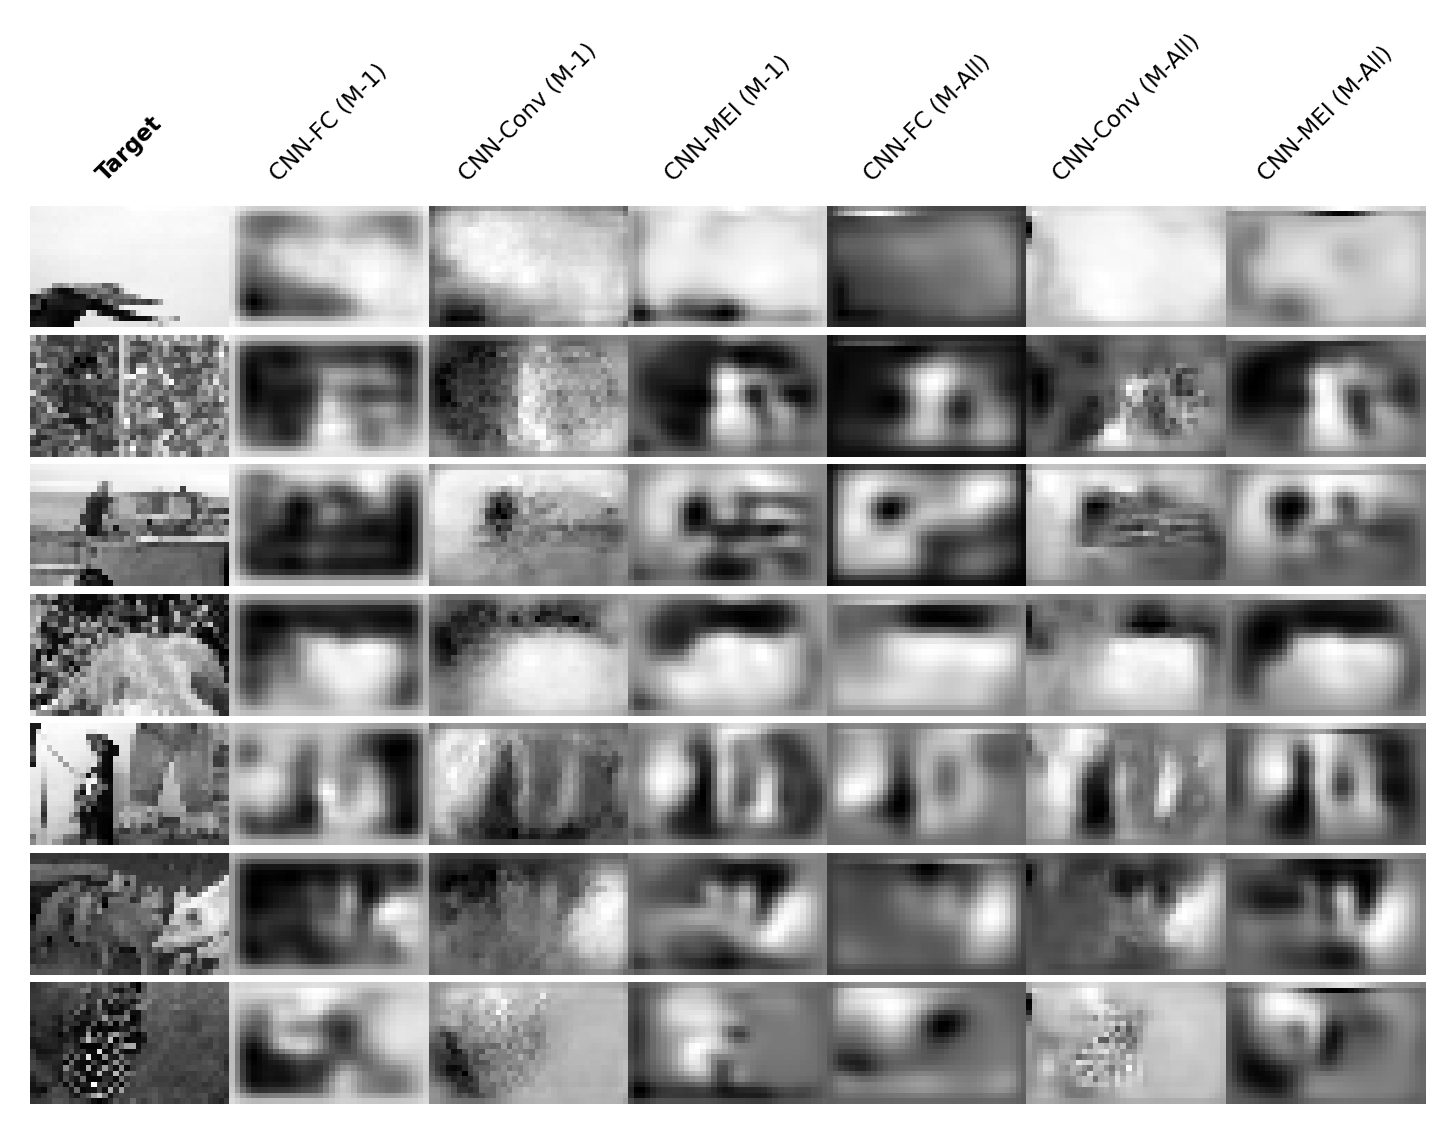

In [34]:
### plot reconstructions
plot_reconstructions_publication(
    runs_to_compare=runs_to_compare,
    stim=stim,
    config=config,
    save_to=os.path.join(config["comparison"]["save_dir"], "reconstructions.pdf") \
        if config["comparison"]["save_dir"] else None,
)

/media/jsobotka/ext_ssd/csng_data/mouse_v1_sensorium22/models/cnn/2024-04-08_00-39-27/decoder.pt


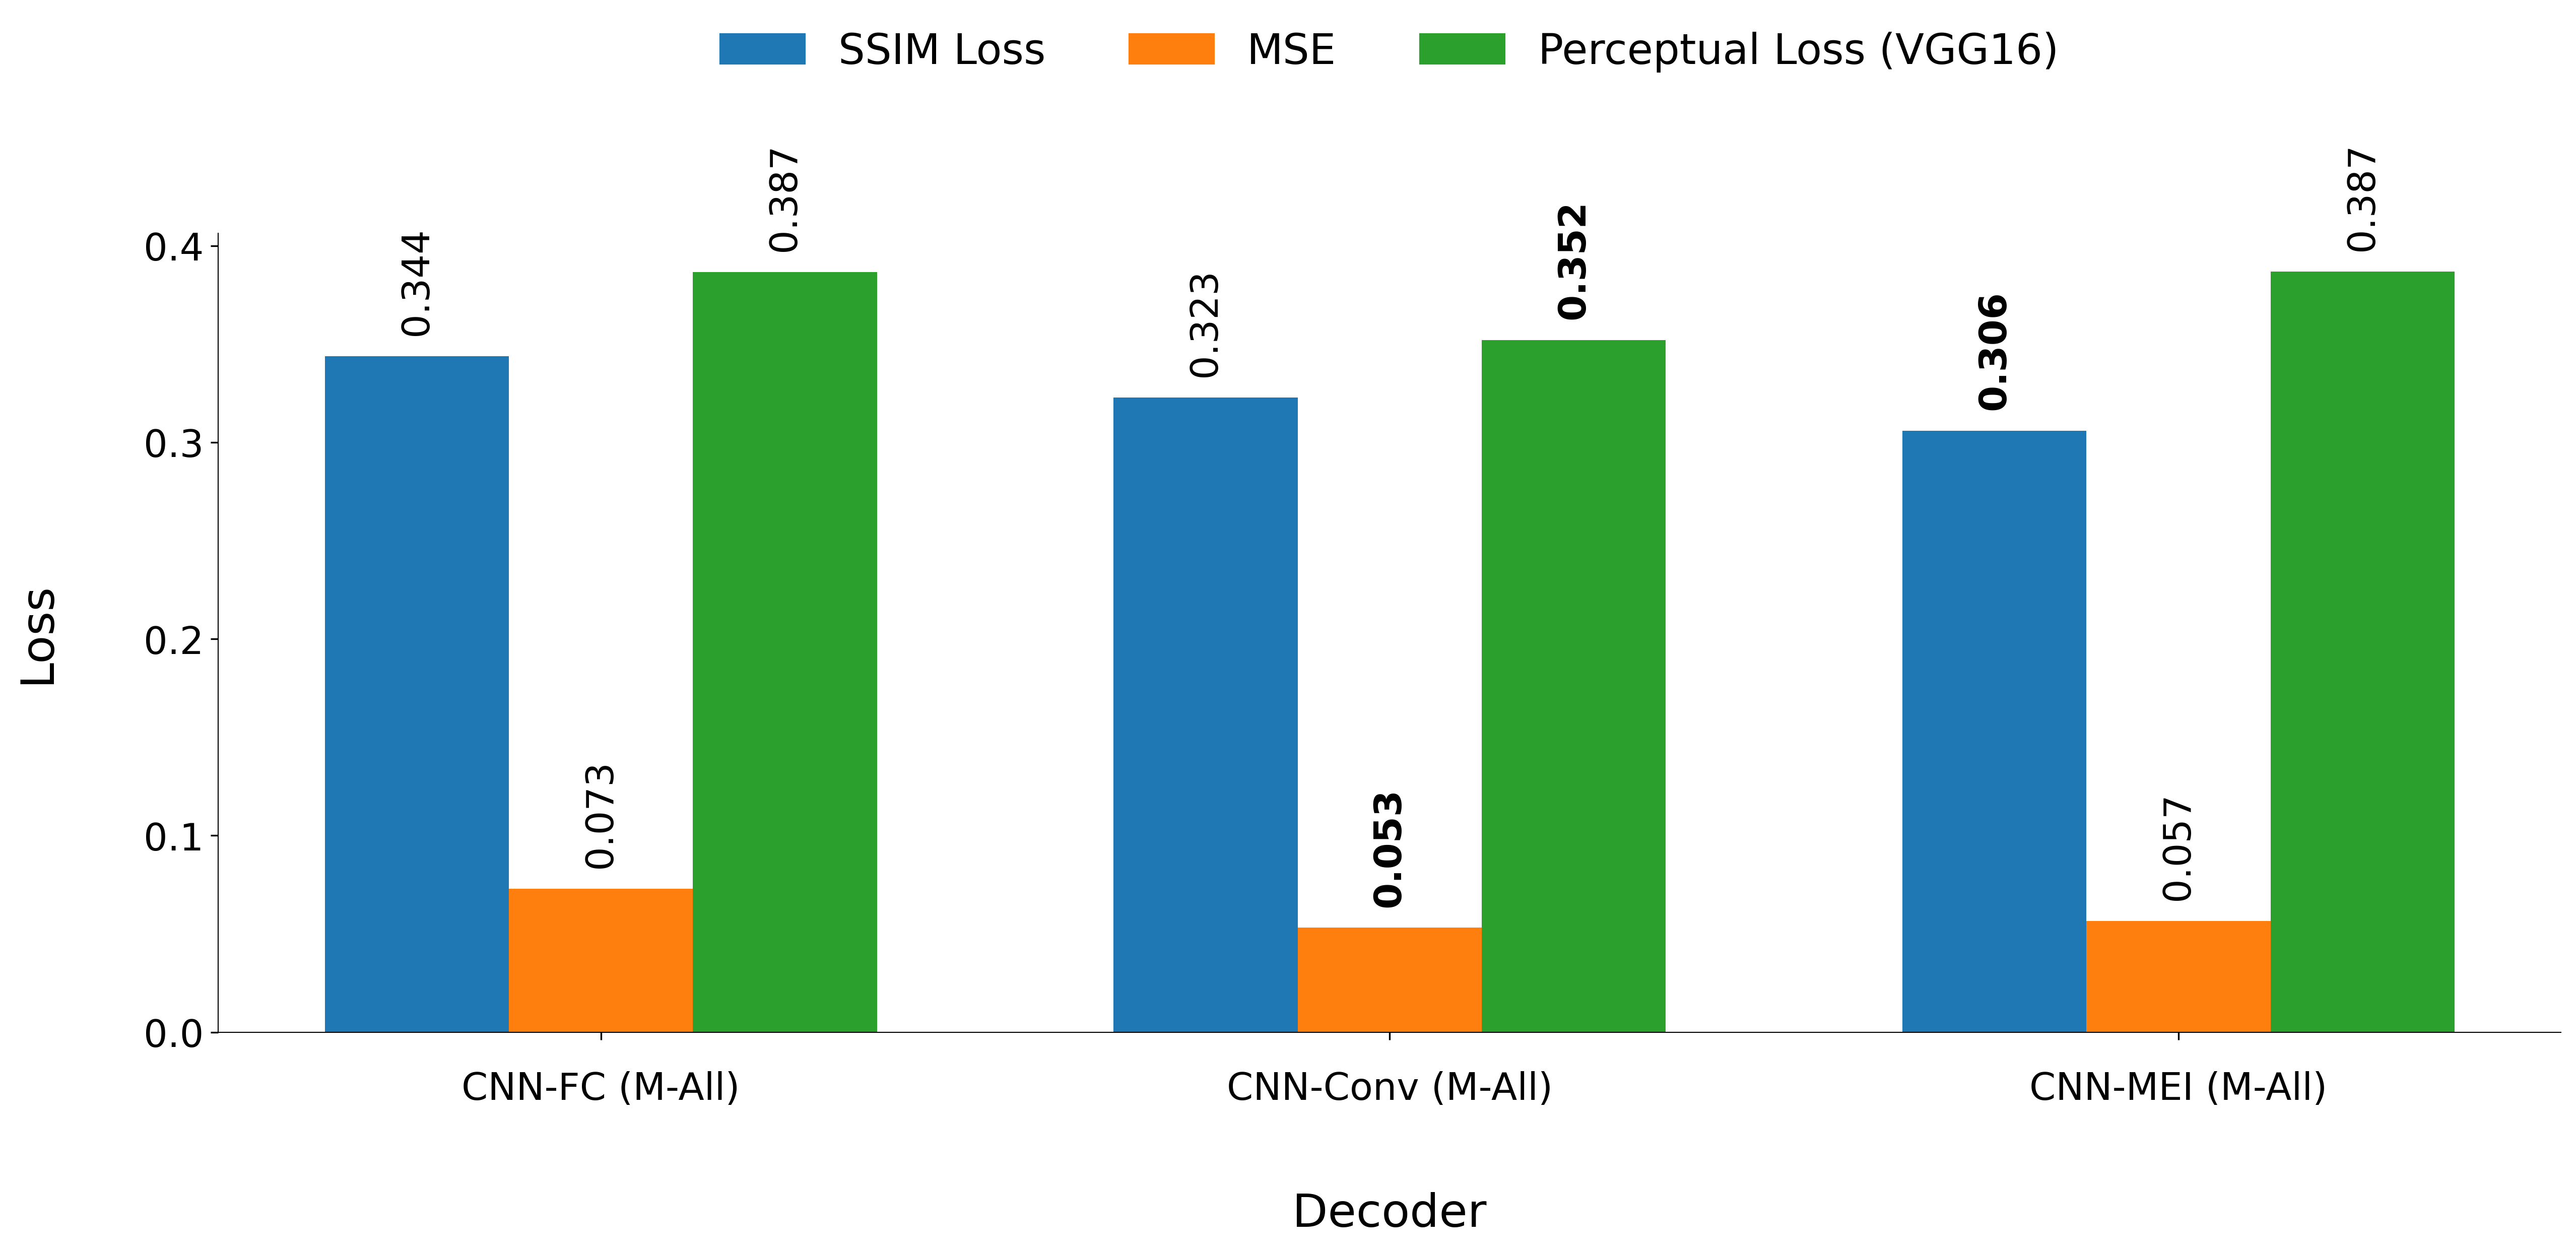

In [49]:
### plot metrics
plot_metrics_publication(
    runs_to_compare=runs_to_compare,
    losses_to_plot=[
        "SSIM Loss",
        # "Log SSIM Loss",
        # "MultiSSIM Loss",
        # "Log MultiSSIM Loss",
        "MSE",
        # "MAE",
        # "FFL",
        "Perceptual Loss (VGG16)",
        # "Perceptual Loss (Encoder)",
    ],
    bar_width=0.7,
    # save_to=os.path.join(config["comparison"]["save_dir"], "metrics.pdf") \
    #     if config["comparison"]["save_dir"] else None,
)

In [ ]:
### plot progression over training
plot_over_training(
    runs_to_compare=runs_to_compare,
    to_plot="val_loss",
    conv_win=10,
    ckpt_idx=0,
)

In [ ]:
### plot metrics
plot_metrics(
    runs_to_compare=runs_to_compare,
    losses_to_plot=[
        "SSIM Loss",
        # "Log SSIM Loss",
        # "MultiSSIM Loss",
        # "Log MultiSSIM Loss",
        "MSE",
        # "MAE",
        # "FFL",
        "Perceptual Loss (VGG16)",
        # "Perceptual Loss (Encoder)",
    ],
    bar_width=0.7,
)

In [ ]:
### plot reconstructions
plot_reconstructions(
    runs_to_compare=runs_to_compare,
    stim=stim,
    config=config,
    loss_fns=loss_fns,
    sample_data_key=sample_data_key,
)